In [152]:
'''
1.Importing Libraries

'''
import pandas as pd
import numpy as np
import pandas as pd
import json
import re
import string
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from collections import Counter


In [153]:
                                  '''DATA PRE-PROCESSING PART-1'''

'DATA PRE-PROCESSING PART-1'

In [154]:
'''
As Stanford data is present in quite complex form with different attributes in 5 files
So,my aim was to just get an (TRAINING,TEST) LIST and (TRAINING,TEST) LABEL

How I achieved clean dataset:
1.Convert SOStr.txt file data in an texts list which contains all examples.
2.Splitlabels contains example id and its part of train,test or label
3.Then from sentiment labels,I created dictionary containing phraseId and sentiment they hold
4.phrase and their is given in dictionary.txt file
'''

def read_text():
    ifname = 'SOStr.txt'
    lines = open(ifname, 'r').read().split('\n')

    texts = []
    for line in lines:
        params = line.split('|')
        if len(params) > 1:
            text = ' '.join(params)
            texts.append(text)

    return texts
texts=read_text()
len(texts)


11855

In [155]:
def read_splitlabel():
    ifname = 'datasetSplit.txt'
    lines = open(ifname, 'r').read().split('\n')

    splitlabels = []
    for line in lines[1:]:
        params = line.split(',')
        if len(params) == 2:
            splitlabels.append(int(params[1]))
    
    return splitlabels
splitlabels=read_splitlabel()
len(splitlabels)


11855

In [156]:
def read_sentiscore():
	ifname = 'sentiment_labels.txt'
	lines = open(ifname, 'r').read().split('\n')

	sentiscores = []
	for line in lines[1:]:
		params = line.split('|')
		if len(params) == 2:
			sentiscores.append(float(params[1]))

	return sentiscores
sentiscores=read_sentiscore()
len(sentiscores)

239232

In [157]:
def read_phraseid():
    ifname = 'dictionary.txt'
    lines = open(ifname, 'r').read().split('\n')

    phraseid = {}
    for line in lines:
        params = line.split('|')
        if len(params) == 2:
            phraseid[params[0]] = int(params[1])

    return phraseid
phraseid=read_phraseid()
# len(phraseid)
# phraseid["The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\\/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth ."]

In [158]:
def prepare_valence():
    texts = read_text()
    splitlabels = read_splitlabel()
    sentiscores = read_sentiscore()
    phraseid = read_phraseid()

    train_text = []
    train_label = []
    
    valid_text = []
    valid_label = []

    test_text = []
    test_label = []

    n_sample = len(texts)
    if n_sample == len(splitlabels) and len(sentiscores) == len(phraseid):
        print('%d samples'%(n_sample))
    else:
        print('reading fail')

    for i, didx in enumerate(splitlabels):
        if didx == 1:
            list_text = train_text
            list_label = train_label
        elif didx == 3:
            list_text = valid_text
            list_label = valid_label
        elif didx == 2:
            list_text = test_text
            list_label = test_label

        list_text.append(texts[i])
        list_label.append(sentiscores[phraseid[texts[i]]])
        
    return train_text,train_label,test_text,test_label,valid_text,valid_label

In [159]:
def labelize(text,label):
        y = []
        for l in label:
            if l <= 0.2:
                y.append(0)
            elif l <= 0.4:
                y.append(1)
            elif l <= 0.6:
                y.append(2)
            elif l <= 0.8:
                y.append(3)
            else:
                y.append(4)
        print(len(y))
        return (text, y)
train_tx,train_l,test_tx,test_l,valid_tx,valid_l=prepare_valence()
train_text,train_label=labelize(train_tx,train_l)    
test_text,test_label=labelize(test_tx,test_l)
valid_text,valid_label=labelize(valid_tx,valid_l)

11855 samples
8544
2210
1101


In [160]:
'''
Now as I have to use AMAZON Phone datset for final testing so I am merging given
Training and validation set as One TRAIN_CORPUS
'''
Train_corpus=train_tx+valid_tx
Train_label=train_label+valid_label

In [161]:
len(Train_corpus)
len(Train_label)

9645

In [163]:
'''
NOW I have  MANIPULATED THE DATASET TO FIT ACCORDING TO MODEL

'''
'''
POSITIVE means review id 2,3,4
NEGATIVE means review id 0,1
Then for binary classification POSITIVE becames 1
                               Neagtive becomes 0
'''

def changing_labels(t_label):
    for i,label in enumerate(t_label):
        if label==1:
            t_label[i]=0
        elif label==2 or label==3 or label==4:
            t_label[i]=1   
    count_positive_reviews=0
    count_negative_reviews=0
    for label in t_label:
        if label==1:
            count_positive_reviews+=1
        else:
            count_negative_reviews+=1
    return t_label,count_positive_reviews,count_negative_reviews

In [164]:
Train_label,count_positive_reviews,count_negative_reviews=changing_labels(Train_label)
test_label,count_positive_reviews_TEST,count_negative_reviews_TEST=changing_labels(test_label)

In [165]:
print("Number of positive reviews are {}".format(count_positive_reviews))
print("Number of negative reviews are {}".format(count_negative_reviews))

Number of positive reviews are 5907
Number of negative reviews are 3738


In [166]:
print("Number of positive reviews are {}".format(count_positive_reviews_TEST))
print("Number of negative reviews are {}".format(count_negative_reviews_TEST))

Number of positive reviews are 1298
Number of negative reviews are 912


In [167]:
print("Number of examples in Train_corpus {}".format(len(Train_corpus)))
print("Number of examples in Train_corpus {}".format(len(test_text)))

Number of examples in Train_corpus 9645
Number of examples in Train_corpus 2210


In [168]:
'''
5.Now Pre-Processing the reviews

5.1:using Porter Stemmer
5.2.Removing Stopwords
5.3.Cleaning the text
5.4.using tweet tokenizer 
5.5.Returning clean reviews
5.6.Arranging words in pair(word,label) in an dict with value as their frequency
'''

def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer() 
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            if(pos_tag([word])[0][1]=='NN'):
                pos='n'
                lemma_word= lemmatizer.lemmatize(stem_word,pos)
            elif(pos_tag([word])[0][1]=='VB'):
                pos='v'
                lemma_word= lemmatizer.lemmatize(stem_word,pos)
            else:
                pos='a'
                lemma_word= lemmatizer.lemmatize(stem_word,pos)
            tweets_clean.append(lemma_word)

    return tweets_clean

In [169]:
def build_freqs(tweets, ys):
    """Build frequencies.
    
    Output will be:
        freqs: a dictionary mapping each (word, sentiment[label 0 or 1]) pair to its
        frequency
    """
    
    # The squeeze is necessary or the list ends up with one element.
    yslist = np.squeeze(ys).tolist()
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [170]:
'''
Frequency
'''
freqs_train = build_freqs(Train_corpus,Train_label)

In [171]:
WORDS=Counter(freqs_train)
WORDS.most_common(10)


[(('film', 1), 974),
 (('movi', 1), 690),
 (('movi', 0), 579),
 (('film', 0), 494),
 (('...', 1), 417),
 (("n't", 0), 410),
 (('one', 1), 396),
 (("n't", 1), 364),
 (('like', 1), 321),
 (('like', 0), 319)]

In [172]:
                                      '''MODEL MAKING PART-3'''

'MODEL MAKING part-3'

In [173]:
'''
8.Defining Naive byes model
'''
def train_naive_bayes(freqs, train_x, train_y):
    
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate N_pos, N_neg, V_pos, V_neg
    N_pos = N_neg = V_pos = V_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:
            # increment the count of unique positive words by 1
            V_pos += 1

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs[pair]

        # else, the label is negative
        else:
            # increment the count of unique negative words by 1
            V_neg += 1

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs[pair]

    # Calculate D, the number of documents
    D = len(Train_corpus)

    # Calculate D_pos, the number of positive documents
    D_pos = count_positive_reviews

    # Calculate D_neg, the number of negative documents
    D_neg = count_negative_reviews

    # Calculate logprior
    logprior = np.log(D_pos)-np.log(D_neg)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = lookup(freqs,word,1.0)
        freq_neg = lookup(freqs,word,0.0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos+1)/(N_pos + (V_pos+V_neg))
        p_w_neg = (freq_neg+1)/(N_neg+ (V_pos+V_neg))

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos)-np.log(p_w_neg)



    return logprior, loglikelihood


In [174]:
def lookup(freqs, word, label):
    n = 0  # freqs.get((word, label), 0)

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

logprior, loglikelihood = train_naive_bayes(freqs_train, Train_corpus, Train_label)
print(logprior)
print(len(loglikelihood))

0.4575873792917271
12554


In [175]:
'''
Predicting on any tweet
'''
def naive_bayes_predict(tweet, logprior, loglikelihood):
    # process the tweet to get a list of words
    word_l = process_tweet(tweet)

    # initialize probability to zero
    p = 0

    # add the logprior
    p += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]
    return p

In [176]:
'''
Giving test data as input to model annp.expm1(Y) checking its accuracy

'''
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    accuracy = 0  # return this properly
    y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i =1.0
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0.0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)
    y_hats=np.asarray(y_hats)
    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.abs(y_hats-test_y))
    precision_score=average_precision_score(test_y,y_hats)
    # Accuracy is 1 minus the error
    accuracy = 1-error
    

    return accuracy,precision_score,y_hats

In [177]:
acc,ps,y_hats=test_naive_bayes(test_text, test_label, logprior, loglikelihood)

In [178]:
print("The accuracy of naive byes model is {}\n".format(acc))
print("the Precision of naive byes model is {}".format(ps))


The accuracy of naive byes model is 0.7339366515837105

the Precision of naive byes model is 0.7103959947429539


In [179]:
                                      '''WEB SCRAPPING PART 4'''

'WEB SCRAPPING PART'

In [222]:
'''
For scrapping task I have to scrap review of 10 phones with each having 10 reviews.
So,The testing will be done on total 100 reviews.
'''
import requests
from bs4 import BeautifulSoup  #I found beautiful soup more faster and easier to use than others.


In [223]:
url_links=[
     'https://www.amazon.in/OnePlus-Nord-Marble-128GB-Storage/product-reviews/B086977J3K/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews',
  'https://www.amazon.in/Apple-iPhone-Xs-512GB-Space/product-reviews/B07J3CJH8S/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews',
  'https://www.amazon.in/Samsung-Galaxy-Storage-Additional-Exchange/product-reviews/B089MQ7C7V/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews'
    ,'https://www.amazon.in/OPPO-Storage-Additional-Exchange-Offers/product-reviews/B086KF4FYC/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews'
    ,'https://www.amazon.in/Samsung-Galaxy-Ocean-128GB-Storage/product-reviews/B07HGGYWL6/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews'
    ,'https://www.amazon.in/Redmi-8A-Dual-Blue-Storage/product-reviews/B07X4R63DF/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews'
    ,'https://www.amazon.in/TECNO-Spark-Comet-Black-Storage/product-reviews/B08HX4RKR1/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews'
    ,'https://www.amazon.in/Apple-iPhone-11-64GB-White/product-reviews/B07XVMCLP7/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews'
    ,'https://www.amazon.in/Nokia-5-3-Android-Smartphone-64/product-reviews/B08GT28WQQ/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews'
    ,'https://www.amazon.in/Redmi-Note-Pebble-Grey-Storage/product-reviews/B086977TR6/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews'
]
url_names=['One Plus Nord 5G','iPhone Xs','Samsung Galaxy Note 20 Ultra 5G','oppo A11K',
           'Samsung Galaxy M31','Redmi 8A dual','Tecno Spark 6 Air','iPhone 11','Nokia 5.3 Android One Smartphone'
          ,'Redmi Note 9 (Pebble Grey, 4GB RAM 64GB Storage)']


In [224]:
def content_request(link):
    page=requests.get(link)
    soup=BeautifulSoup(page.content,'html.parser')
    rating=soup.find_all('i',class_='review-rating')
    review=soup.find_all('span',{"data-hook":"review-body"})
    reviews=cleaner(review)
    ratings=cleaner(rating)
    ratings.pop(0)
    ratings.pop(0)
    
    return ratings,reviews
                         
    

In [225]:
def cleaner(corpus):
    list_to_append=[]
    for i in range(0,len(corpus)):
        list_to_append.append(corpus[i].get_text())
        
    list_to_append[:]=[text.strip('\n') for text in list_to_append]
    
    return list_to_append

In [226]:
Test_corpus=[]
Test_labels=[]
count=0
for i in range(0,len(url_links)):
    link=url_links[i]
    rate,text=content_request(link)
    
    Test_corpus+=text
    Test_labels+=rate

In [227]:
len(Test_corpus)

100

In [228]:
len(Test_labels)

100

In [229]:
Test_labels[:]=[t[0] for t in Test_labels]
for i in range(0, len(Test_labels)): 
    Test_labels[i] = int(Test_labels[i]) 
    if Test_labels[i]==1 or Test_labels[i]==2:
        Test_labels[i]=0
    else:
        Test_labels[i]=1

In [230]:
accuracy_amazon,precison_amazon,predicted_values=test_naive_bayes(Test_corpus, Test_labels, logprior, loglikelihood)

In [231]:
print("The accuracy of naive byes model is {}\n".format(accuracy_amazon))
print("the Precision of naive byes model is {}".format(precison_amazon))


The accuracy of naive byes model is 0.78

the Precision of naive byes model is 0.7314337568058076


In [233]:
True_predictions=0
False_predictions=0
for i,v in enumerate(predicted_values):
    if Test_labels[i]==v:
        True_predictions+=1
    else:
        False_predictions+=1

In [234]:
True_predictions

78

In [235]:
False_predictions

22

<Figure size 720x504 with 0 Axes>

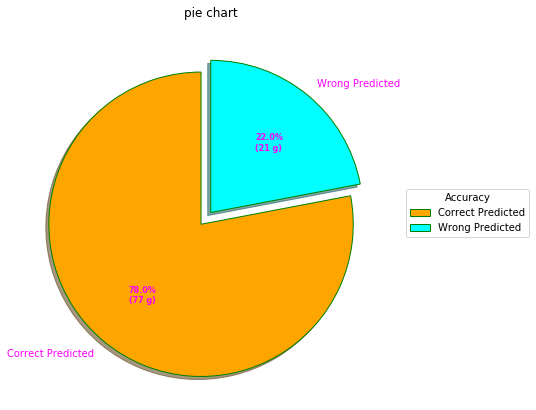

In [236]:
                                '''  EXPLORATORY DATA ANALYSIS(EDA) PART 2  '''
    
#USING PIE CHART TO VIEW HOW MANY TIMES DIFFERENT SENTIMENT OCCUR
count=Counter(train_label)
fig=plt.figure(figsize=(10,7))
occurence_list=[True_predictions,False_predictions]
label_for_pie=['Correct Predicted','Wrong Predicted']
# Creating explode data 
explode = (0.1, 0.0) 
  # Creating color parameters 
colors = ( "orange", "cyan") 
# Wedge properties 
wp = { 'linewidth' : 1, 'edgecolor' : "green" } 
  # Creating autocpt arguments 
def func(pct, allvalues): 
    absolute = int(pct / 100.*np.sum(allvalues)) 
    return "{:.1f}%\n({:d} g)".format(pct, absolute) 
  # Creating plot 
fig, ax = plt.subplots(figsize =(10, 7)) 
wedges, texts, autotexts = ax.pie(occurence_list,  
                                  autopct = lambda pct: func(pct, occurence_list), 
                                  explode = explode,  
                                  labels = label_for_pie, 
                                  shadow = True, 
                                  colors = colors, 
                                  startangle = 90, 
                                  wedgeprops = wp, 
                                  textprops = dict(color ="magenta")) 
  # Adding legend 
ax.legend(wedges, label_for_pie, 
          title ="Accuracy", 
          loc ="center left", 
          bbox_to_anchor =(1, 0, 0.5, 1)) 
plt.setp(autotexts, size = 8, weight ="bold") 
ax.set_title("pie chart") 
  # show plot 
plt.show() 